In [1]:
%load_ext autoreload
%autoreload 2

from ctapipe.io import event_source
import sys
 
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import sys
from scipy.stats import norm
from traitlets.config.loader import Config 
from ctapipe import utils

# ctapipe modules
from ctapipe.visualization import CameraDisplay
from ctapipe.plotting.camera import CameraPlotter
from ctapipe.image.extractor import *
from ctapipe_io_lst.containers import PedestalContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader

# lst modules
#sys.path.insert(0,'/astro/users/cassol/soft/python/cta-lstchain')
#sys.path.insert(0,'/astro/users/cassol/soft/python/ctapipe_io_lstchain')

from lstchain.calib.camera.r0 import LSTR0Corrections

r0calib = LSTR0Corrections(
    pedestal_path="/astro/users/cassol/soft/python/lstchain-test/pedestal_run97_new.fits",
    r1_sample_start=2,r1_sample_end=38)



# flat field run with interleaved flatfield and pedestal events (for the moment to big for cta-lstchain-extra)
run = 251
file = '/ctadata/franca/LST/LST-1.1.Run00{0}.0000.fits.fz'.format(run)
reader = event_source(file, max_events=None)

channel=['HG','LG']
# use the tool to write calibration coefficients
from lstchain.tools.calc_camera_calibration import CalibrationHDF5Writer

tel_id=0 # LST1 for the moment

In [3]:
# read first flatfield event

for i, event in enumerate(reader): 

    # select only flatfield events    
    if event.r0.tel[0].trigger_type == 32:        
        continue
           
    # calibrate r0 --> r1        
    r0calib.calibrate(event)
    
    break
        
print(f"read event id: {event.r0.event_id}, trigger {event.r0.tel[0].trigger_type}")
        

read event id: 6, trigger 1


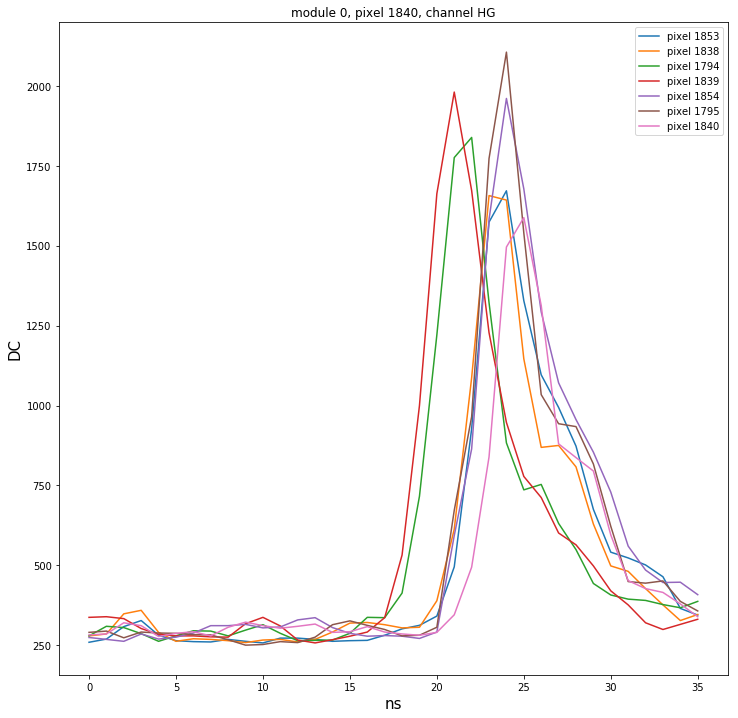

In [4]:
# plot R1 waveform of module [module]
def view_waveform(chan=0, pix_id=6,i=0):
    waveform = event.r1.tel[tel_id].waveform
    plt.plot(waveform[chan, pix_id], label=f'pixel {pix_id}')
  
    plt.title(f"module {module}, pixel {pix_id}, channel {channel[chan]}",)
    max_now=waveform[chan, pix_id].max()
    min_now=waveform[chan, pix_id].min()


    plt.legend()
    plt.ylabel('DC',fontsize=15) 
    plt.xlabel('ns',fontsize=15)
    

# module number    
module=0
# channel
chan=0
# ids of pixel in module
pixels_mod=event.lst.tel[0].svc.pixel_ids[module*7:module*7+7]
 
fig = plt.figure(num=0,figsize=(12,12))     

for i,pix  in enumerate(pixels_mod):    

    view_waveform(chan=chan, pix_id=pix,i=i)
    
#plt.savefig(f"Run{run}_low_level_correction_{channel[chan]}_mod{modu}.png")    

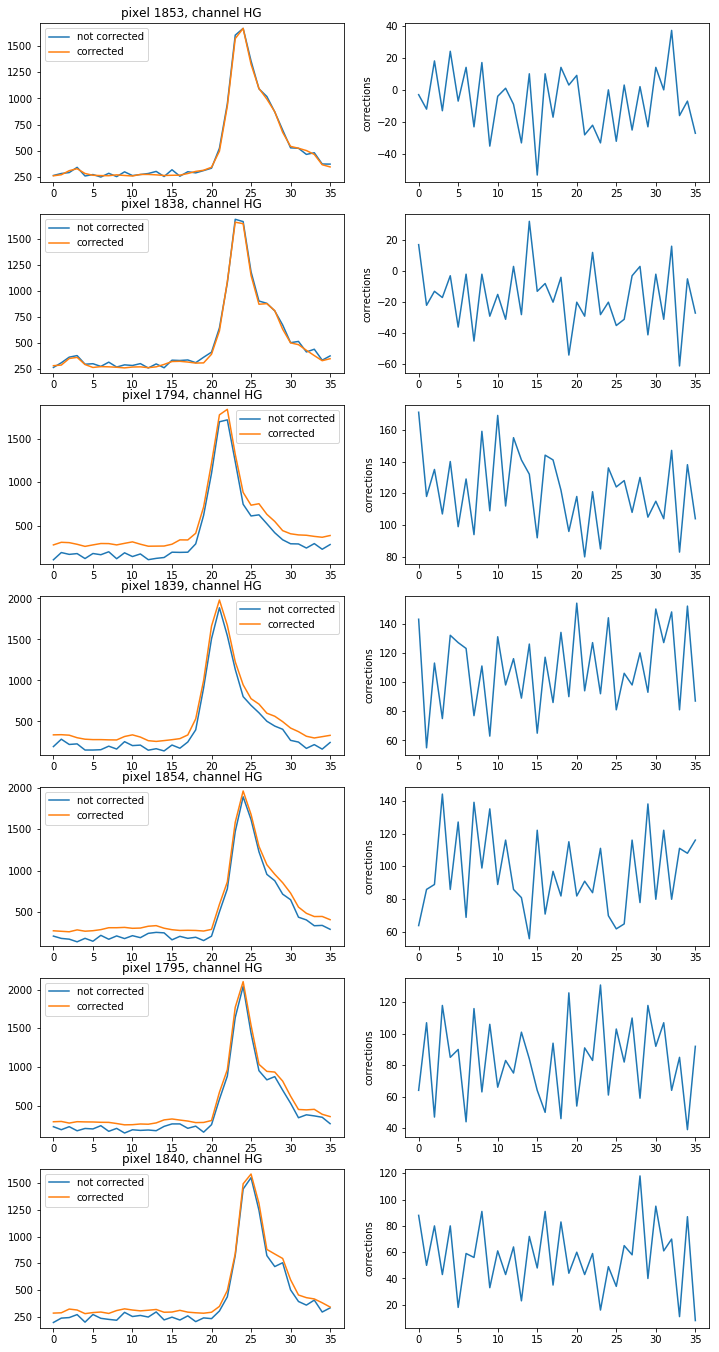

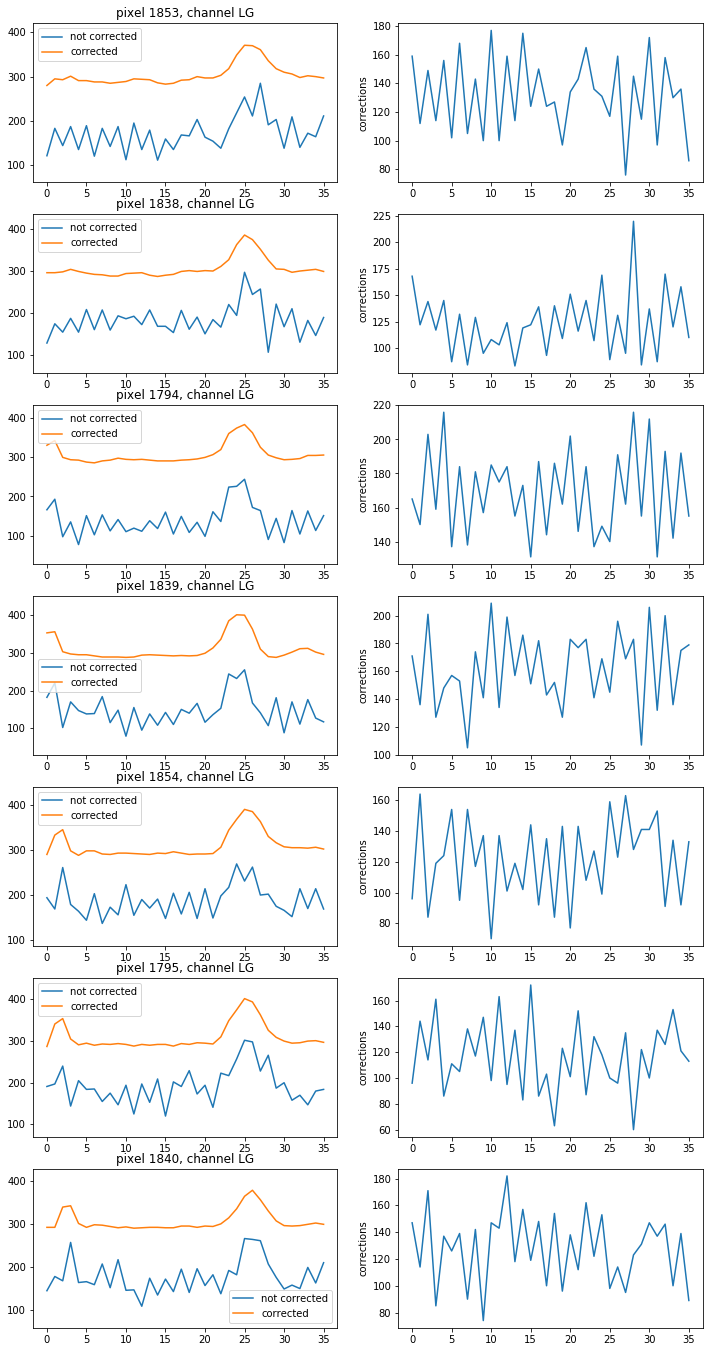

In [5]:
# plot effect of low-level calibration on module 
def view_waveform(chan=0, pix_id=6,i=0):

    plot_id=i*2+1
    plt.subplot(7,2,plot_id)
 
    plt.plot(event.r0.tel[tel_id].waveform[chan, pix_id,2:38], label='not corrected')
    plt.plot(event.r1.tel[tel_id].waveform[chan, pix_id], label='corrected') 
    
    plt.title(f"pixel {pix_id}, channel {channel[chan]}",)
    
    mymax=max(newwaveform[chan, pix_id].max(),oldwaveform[chan, pix_id].max()) + 50
    mymin=min(newwaveform[chan, pix_id].min(),oldwaveform[chan, pix_id].min()) - 50
    
    plt.ylim(mymin,mymax)
    plt.legend()
    plot_id=(i*2)+2
    
    plt.subplot(7,2,plot_id)
    plt.plot(newwaveform[chan, pix_id]-oldwaveform[chan, pix_id])
    plt.ylabel('corrections',fontsize=10) 
    
# module number    
module=0

# ids of pixel in module
pixels_mod=event.lst.tel[0].svc.pixel_ids[module*7:module*7+7]
 # r0
newwaveform = event.r1.tel[tel_id].waveform
# R1
oldwaveform = event.r0.tel[tel_id].waveform[:,:,2:38]

for i,pix  in enumerate(pixels_mod):
    
    for chan in(np.arange(2)): 
        
        plt.figure(num=chan,figsize=(12,24)) 
        # plot waveform of selected channel
        view_waveform(chan=chan, pix_id=pix,i=i)
    
#plt.savefig(f"Run{run}_low_level_correction_{channel[chan]}_mod{modu}.png")    

channel HG: mean 11112.437735849056 +- 2074.038744327004
channel LG: mean 3929.445822102426 +- 274.4903577518119


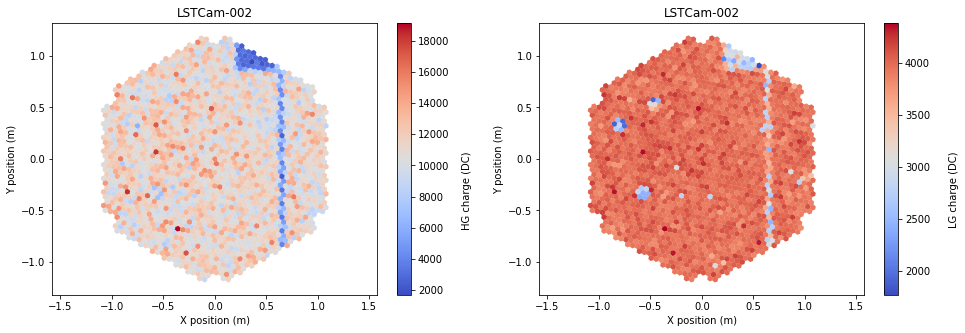

In [6]:
# integrate the charge on 12 ns around the peak value

config = Config({
    "LocalPeakWindowSum": {
        "window_shift": 5,
        "window_width": 12 
    }
})
integrator = LocalPeakWindowSum(config=config)


waveform=event.r1.tel[0].waveform
image, peakpos = integrator(waveform)

fig = plt.figure(figsize=(16, 5))

chan =0
ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
#disp.set_limits_minmax(2000,4000)
disp.axes.text(2.4, 0, f'{channel[chan]} charge (DC)', rotation=90)
disp.add_colorbar()
print(f"channel {channel[chan]}: mean {image[chan].mean()} +- {image[chan].std()}")

ax = plt.subplot(1, 2, 2)
chan =1
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.image = image[chan]  
#disp.set_limits_minmax(2000,4000)
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, f'{channel[chan]} charge (DC)', rotation=90)

disp.add_colorbar()
print(f"channel {channel[chan]}: mean {image[chan].mean()} +- {image[chan].std()}")

#plt.savefig(f"Run{run}_event_{event.lst.tel[0].evt.event_id}.png")   

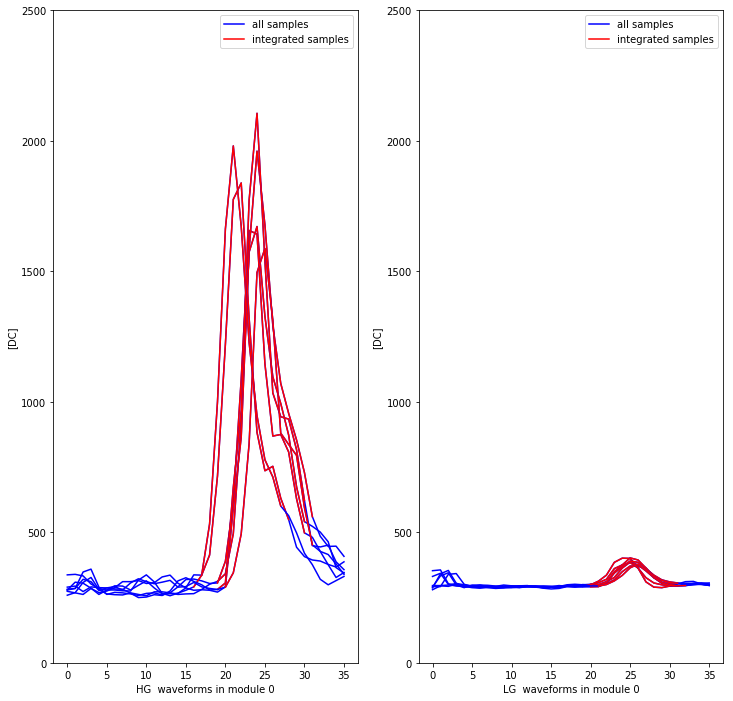

In [7]:
# Plot the part of the waveform that is integrated
# (this work only after the line above)

fig = plt.figure(0,figsize=(12,12))

# consider only 36 samples
samples=np.arange(0,36)

# chose the module
mod = 0

# find pixel index in module
pix_in_mod = event.lst.tel[0].svc.pixel_ids[mod*7:mod*7+7]

for chan in(np.arange(2)): 

    plt.subplot(1,2,chan+1)
    
    for i,pix in enumerate(pix_in_mod):
    
        # samples used to calculate the charge
        start=int(peakpos[chan,pix]-integrator.window_shift)
        stop=int(start+integrator.window_width)
        used_samples=np.arange(start,stop)
        used=waveform[chan,pix,start:stop]
        
            
        plt.plot(waveform[chan,pix,], color='b', label='all samples')
        plt.plot(used_samples,used, color='r', label='integrated samples')
        if i==0:
            plt.legend()
        plt.ylabel("[DC]")
        plt.xlabel(f"{channel[chan]}  waveforms in module {mod}")
        plt.ylim(0,2500)
        fig.savefig(f"Run{run}_waverforms_module_{mod}.png")



new pedestal at event n. 974 (242)
new flatfield at event n. 1666 (415)
new pedestal at event n. 1866 (465)
new flatfield at event n. 2342 (584)


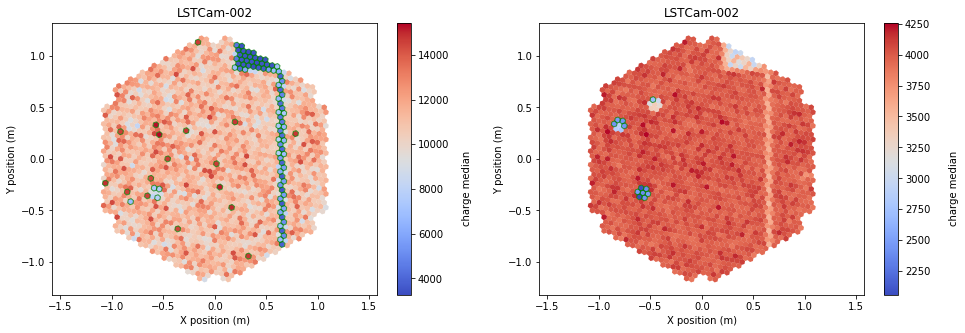

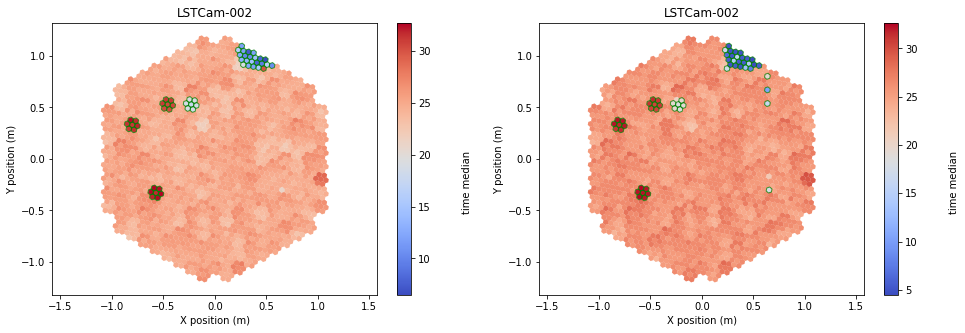

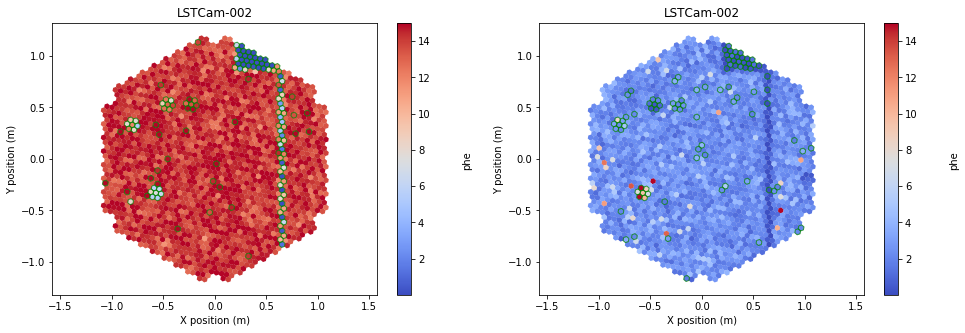

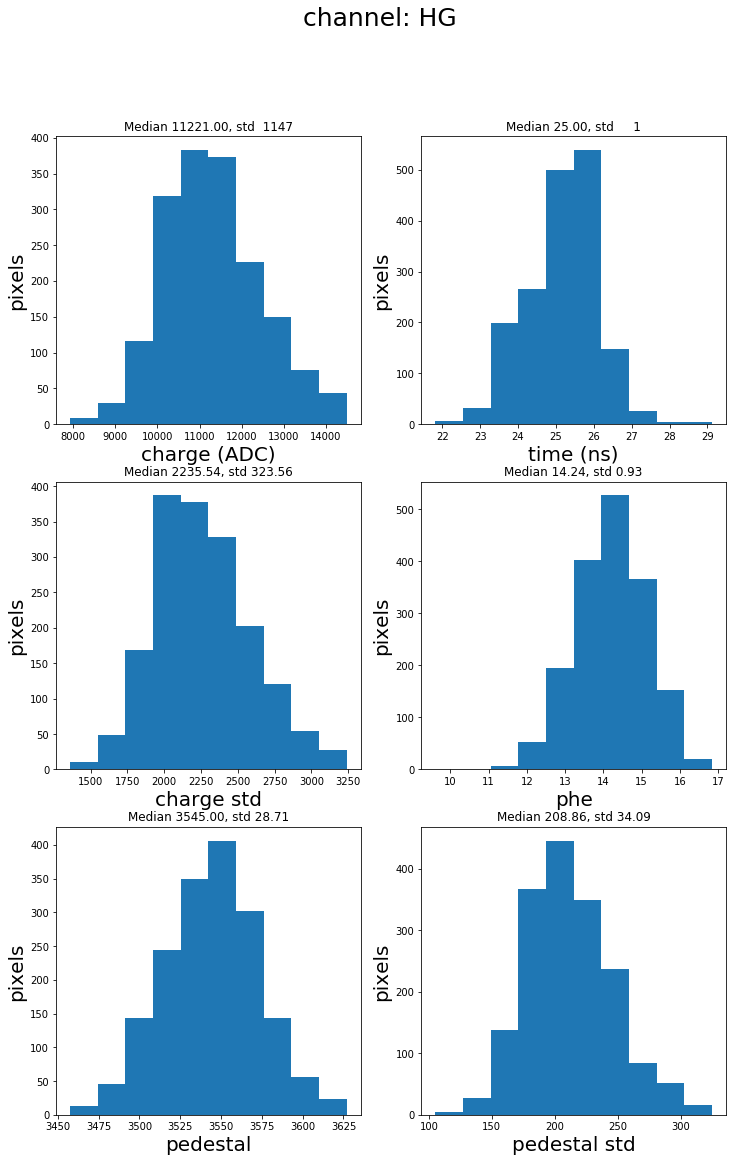

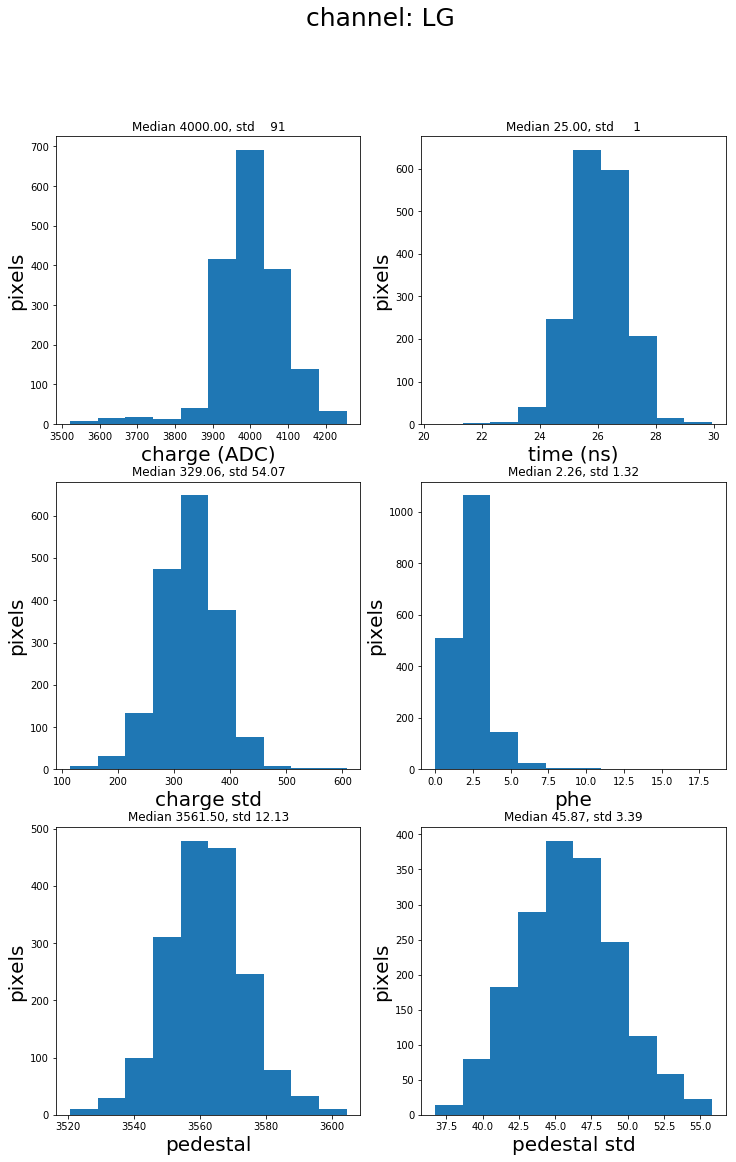

In [8]:
# flat field calculations

from lstchain.calib.camera.pedestals import PedestalIntegrator
from lstchain.calib.camera.flatfield import FlasherFlatFieldCalculator


# configuration for the pedestal charge integrator
ped_config = Config({
    "FixedWindowSum": {
        "window_start": 12,
        "window_width": 12,
    }    
})

# configuration for the flatfield charge integrator
ff_config = Config({
    "LocalPeakWindowSum": {
        "window_shift": 5,
        "window_width": 12,
    }    
    
})

ped_calculator = PedestalIntegrator(tel_id=0,
                                    sample_size=100,
                                    charge_median_cut_outliers = [-3,3],
                                    charge_std_cut_outliers = [-3,3],
                                    charge_product="FixedWindowSum",
                                    config=ped_config)


ff_calculator = FlasherFlatFieldCalculator(tel_id = 0,
                                           sample_size=100,
                                           sample_duration = 1000,
                                           charge_cut_outliers = [-0.3,0.3],
                                           time_cut_outliers = [20,30],
                                           charge_product = "LocalPeakWindowSum",
                                           config=ff_config)

calib_event=0
ped_event = False
ped_initialized = False
initialized = False
for i, event in enumerate(reader): 
    
    if not initialized:
        ped_data = event.mon.tel[tel_id].pedestal 
        ff_data = event.mon.tel[tel_id].flatfield
        status_data = event.mon.tel[tel_id].pixel_status
    
    # create r1 
    r0calib.calibrate(event)    
       
    # if pedestal event
    if event.lst.tel[0].evt.tib_masked_trigger == 32:    
        if ped_calculator.calculate_pedestals(event):
            
            ped_event = True
            print(f"new pedestal at event n. {event.r0.event_id} ({i+1})")
                        
            # update pedestal mask
            event.mon.tel[0].pixel_status.pedestal_mask=np.logical_or(ped_data.charge_median_outliers,
                                                                  ped_data.charge_std_outliers)   
    
    # consider flat field events only after first pedestal event (for pedestal mask initalization)
    elif event.lst.tel[0].evt.tib_masked_trigger == 1 and ped_event:
        
        if ff_calculator.calculate_relative_gain(event):
            calib_event+=1
            print(f"new flatfield at event n. {event.r0.event_id} ({i+1})")                                                          
            
            # consider values only after first flat field event (for flat field mask initalitation)
            if calib_event > 1:
                cal_charge = ff_data.charge_median
                phe = 1.2*(ff_data.charge_median-ped_data.charge_median)**2/(ff_data.charge_std**2 - ped_data.charge_std**2)
               
                cal= phe/ff_data.charge_median
                
                # calculate global mask from outliers
                mask_ff=np.logical_or(ff_data.charge_median_outliers,
                                        ff_data.time_median_outliers)
                mask_ped = np.logical_or(ped_data.charge_median_outliers,
                                        ped_data.charge_std_outliers)  
                mask_phe= np.logical_or(mask_ff, mask_ped)
                
                masked_phe = np.ma.array(phe, mask=mask_phe)
    
                # F2 factor
                F2 =1.2
                # calculate photon-electrons
                phe = F2*(ff_data.charge_median - ped_data.charge_median)**2/(ff_data.charge_std**2 - ped_data.charge_std**2)
                median_value=np.ma.median(masked_phe)
                
            # stop at the third event    
            if calib_event == 3:
                break
            
            event.mon.tel[0].pixel_status.flatfield_mask=np.logical_or(ff_data.charge_median_outliers,
                                                                       ff_data.time_median_outliers)
    
# plot results            
fig = plt.figure(10,figsize=(16, 5))
    
chan =0
image = ff_data.charge_median
mask=  ff_data.charge_median_outliers 
ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'charge median', rotation=90)
disp.add_colorbar()

ax = plt.subplot(1, 2, 2)
chan=1
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
disp.axes.text(2.4, 0, 'charge median', rotation=90)
fig.savefig(f"Run{run}_chrge_median.png")        
fig = plt.figure(11,figsize=(16, 5))
mask=  ff_data.time_median_outliers 
        
image = ff_data.time_median
chan =0
        
ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
disp.axes.text(2.4, 0, 'time median', rotation=90)
ax = plt.subplot(1, 2, 2)
chan =1
        
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'time median', rotation=90)
disp.add_colorbar()   
fig.savefig(f"Run{run}_time_median.png") 


mask=np.logical_or(event.mon.tel[0].pixel_status.flatfield_mask,
                    event.mon.tel[0].pixel_status.pedestal_mask) 

fig = plt.figure(15,figsize=(16, 5))

    
chan =0
#my_mask = np.logical_or(mask,cal_charge==0)
image = np.ma.array(masked_phe, mask = mask)
image = phe
ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
disp.set_limits_minmax(0.005,15)
disp.axes.text(2.4, 0, 'phe', rotation=90)
ax = plt.subplot(1, 2, 2)


chan =1         
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.set_limits_minmax(0.0005,15)
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'phe', rotation=90)
disp.add_colorbar()   

fig.savefig(f"Run{run}_phe.png") 

#mask=ff_data.time_median_outliers
for chan in np.arange(2):
        n_phe = phe[chan]
        median_gain = ff_data.relative_gain_median[chan]
        median_relative_time = ff_data.relative_time_median[chan]
        median_charge = ff_data.charge_median[chan]
        std_charge = ff_data.charge_std[chan]
        std_time = ff_data.time_std[chan]
        median_time = ff_data.time_median[chan]
        median_ped = ped_data.charge_median[chan]
        std_ped = ped_data.charge_std[chan]
        
       
        select = np.logical_not(mask[chan])
        #select = mask[chan]
              
              
        #plt.title(f" channel {chan}")
        fig = plt.figure(chan,figsize=(12,18))
        fig.suptitle(f"channel: {channel[chan]}", fontsize=25) 
        plt.subplot(321)
        median= int(np.median(median_charge[select])) 
        rms= np.std(median_charge[select])
        plt.title(f"Median {median:3.2f}, std {rms:5.0f}") 
        plt.xlabel('charge (ADC)',fontsize=20)
        plt.ylabel('pixels',fontsize=20) 
        plt.hist(median_charge[select])  
        plt.subplot(322)
        plt.ylabel('pixels',fontsize=20) 
        plt.xlabel('time (ns)',fontsize=20)            
        plt.hist(median_time[select])

        median= int(np.median(median_time[select])) 
        rms= np.std(median_time[select])
        plt.title(f"Median {median:3.2f}, std {rms:5.0f}") 
      
        plt.subplot(323)
       # plt.ylabel('pixels',fontsize=20) 
       # plt.xlabel('relative gain',fontsize=20) 
       # median= np.median(median_gain[select])
       # rms= np.std(median_gain[select])
       # plt.title(f"Median {median:3.2f}, std {rms:3.2f}") 
       # plt.hist(median_gain[select])
        
        plt.ylabel('pixels',fontsize=20) 
        plt.xlabel('charge std',fontsize=20) 
        median= np.median(std_charge[select])
        rms= np.std(std_charge[select])
        plt.title(f"Median {median:3.2f}, std {rms:3.2f}") 
        plt.hist(std_charge[select])
                
        plt.subplot(324) 
        plt.ylabel('pixels',fontsize=20) 
        plt.xlabel('phe',fontsize=20) 
        median= np.median(n_phe[select])
        rms= np.std(n_phe[select])
                
        plt.title(f"Median {median:3.2f}, std {rms:3.2f}") 
        plt.hist(n_phe[select])       
        plt.subplot(325)
        plt.ylabel('pixels',fontsize=20) 
        plt.xlabel('pedestal',fontsize=20) 
        median= np.median(median_ped[select])
        rms= np.std(median_ped[select])
                
        plt.title(f"Median {median:3.2f}, std {rms:3.2f}") 
        plt.hist(median_ped[select])             
        plt.subplot(326)
        plt.ylabel('pixels',fontsize=20) 
        plt.xlabel('pedestal std',fontsize=20) 
        median= np.median(std_ped[select])
        rms= np.std(std_ped[select])
                
        plt.title(f"Median {median:3.2f}, std {rms:3.2f}") 
        plt.hist(std_ped[select])             
        fig.savefig(f"Run{run}_chan_{chan}.png") 
        

In [9]:
# use the tool to write calibration coefficients
from lstchain.tools.calc_camera_calibration import CalibrationHDF5Writer
calibration_tool= CalibrationHDF5Writer()
calibration_tool.print_help()

Generate a HDF5 file with camera calibration coefficients

Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--input_file=<Unicode> (EventSource.input_url)
    Default: ''
    Path to the input file containing events.
--max_events=<Int> (EventSource.max_events)
    Default: None
    Maximum number of events that will be read from the file
--pedestal_file=<Unicode> (LSTR0Corrections.pedestal_path)
    Default: ''
    Path to the LST pedestal binary file
--flatfield_product=<CaselessStrEnum> (CalibrationHDF5Writer.flatfield_product)
    Default: 'FlasherFlatFieldCalculator'
    Choices: ['FlasherFlatFieldCalculator']
    FlatFieldCalculator to use.
--pedestal_product=<CaselessStrEnum> (CalibrationHDF5Writer.pedestal_product)
    Default: 'PedestalIntegrator'
    Choices: ['PedestalIntegrator']
    PedestalCalculator to use.
--r0calibr

In [10]:
# 
calibration_tool.run(argv=['--config','/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/camera_calibration_param.json'])

INFO [CalibrationHDF5Writer] (tool/initialize): ctapipe version 0.6.2.post146+gite542ebb
INFO [CalibrationHDF5Writer] (tool/run): Starting: CalibrationHDF5Writer
DEBUG [CalibrationHDF5Writer] (tool/run): CONFIG: {'CalibrationHDF5Writer': {'config_file': '/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/camera_calibration_param.json', 'flatfield_product': 'FlasherFlatFieldCalculator', 'pedestal_product': 'PedestalIntegrator', 'r0calibrator_product': 'LSTR0Corrections', 'output_file': 'calibration.hdf5', 'log_level': 'DEBUG'}, 'EventSource': {'input_url': '/ctadata/franca/LST/LST-1.1.Run00251.0000.fits.fz', 'max_events': 1000}, 'PedestalCalculator': {'sample_size': 100, 'sample_duration': 1000, 'tel_id': 0, 'charge_median_cut_outliers': [-3, 3], 'charge_std_cut_outliers': [-3, 3], 'charge_product': 'FixedWindowSum'}, 'FlatFieldCalculator': {'sample_size': 100, 'sample_duration': 1000, 'tel_id': 0, 'charge_product': 'LocalPeakWindowSum', 'charge_cut_outliers': [-0.3, 0.3], 'tim

{'sample_time': <Quantity 0. s>, 'sample_time_range': <Quantity [0., 0.] s>, 'n_events': 100, 'charge_mean': array([[9452.81, 8794.54, 7394.72, ..., 7154.58, 9102.92, 9533.25],
       [2568.9 , 2532.71, 2440.42, ..., 2384.46, 2543.92, 2537.61]]), 'charge_median': array([[9852. , 9206. , 7606.5, ..., 7501. , 9383. , 9800.5],
       [2608.5, 2589. , 2473. , ..., 2419. , 2578. , 2593.5]]), 'charge_std': array([[2184.26375557, 1953.96637852, 1594.89027259, ..., 1551.29587236,
        2244.95124972, 2274.31947349],
       [ 184.37388644,  251.36906313,  176.83835444, ...,  191.62256756,
         210.78641702,  278.83991447]]), 'time_mean': array([[24.28204093, 24.11990043, 24.94389402, ..., 24.20243416,
        22.99860482, 23.49758372],
       [25.17514854, 25.08498255, 26.21945783, ..., 25.17008713,
        23.94691708, 23.59548433]]), 'time_median': array([[24.99918844, 24.71395661, 26.04770143, ..., 25.03019172,
        23.37279673, 24.15482934],
       [25.94684303, 25.99687177, 27.002

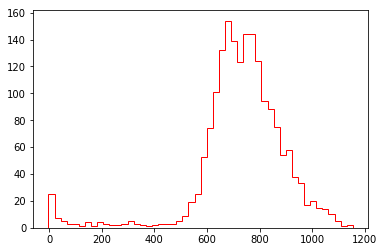

In [11]:
# read back the monitoring containers written with the tool calc_camera_calibration.py
from ctapipe_io_lst.containers import FlatFieldContainer, WaveformCalibrationContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader
ff_data = FlatFieldContainer()
cal_data =  WaveformCalibrationContainer()

with HDF5TableReader('/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/calibration.hdf5') as h5_table:

    assert h5_table._h5file.isopen == True

    for cont in h5_table.read('/tel_0/flatfield', ff_data):
            print(cont.as_dict())
            
    for cont in h5_table.read('/tel_0/calibration', cal_data):
            print(cont.as_dict())
            plt.hist(1/cont.dc_to_phe[0], color='r', histtype='step', bins = 50, stacked=True, fill=False)
                    
h5_table.close() 